# Analysis with Digital Elevation Models (DEMs)
Bodo Bookhagen

This Notebook describes how to use Python to do some simple but instructive DEM analysis. We will start by generating a Gaussian hill. Because we can take the analytical derivative of the 2D Gaussian function, we can compare gridded slope estimates with analytical solution to better understand the true nature of slope (and aspect) calculations. In a second step, we will compare slope distributions derived from different DEM resolutions - again using the Gaussian Hill as an example that we sample at different resolutions.

Consider the 2D Gaussian Function:
$$G(x,y,\sigma) = \frac{1}{2\pi \sigma^2} e^{-\frac{x^2 + y^2}{2 \sigma^2}}$$

For our purposes, we will use a constant $\sigma=1$ and simplify
$$G(x,y,) = e^{-x^2 - y^2}$$

When taking the analytical solution, you can simplify this by assuming same x and y distances and stepsize and replace (x,y) with the distance $r$.


## Python implenentation of an analytical Gaussian function and derivative
Generating a gridded version of this Gaussian Function in Python with a fixed x and y frame (running from -2.5 to +2.5) and returning the corresponding $x, y, z$ values. Similarily, this can be done for the first and second derivative (slope and curvature). 

In [17]:
import numpy as np
from matplotlib import pyplot as pl
pl.rcParams['figure.figsize'] = [14, 7]

def gaussian_hill_elevation(n, b = 2.5):
    x, y = np.meshgrid(np.linspace(-b,b,n),
                       np.linspace(-b,b,n))
    z = np.exp(-x*x-y*y)
    return (x, y, z)

def gaussian_hill_slope(n, b = 2.5):
    x, y = np.meshgrid(np.linspace(-b,b,n),
                       np.linspace(-b,b,n))
    r = np.sqrt(x*x+y*y)
    return 2*r*np.exp(-r*r)

def gaussian_hill_curvature(n, b = 2.5):
    x, y = np.meshgrid(np.linspace(-b,b,n),
                       np.linspace(-b,b,n))
    r = np.sqrt(x*x+y*y)
    return (1 - 2*r*r)*2*np.exp(-r*r)

These can be visualized with the Matplotlib in 2D and 3D. The 3D plot is interactive and can be rotated.

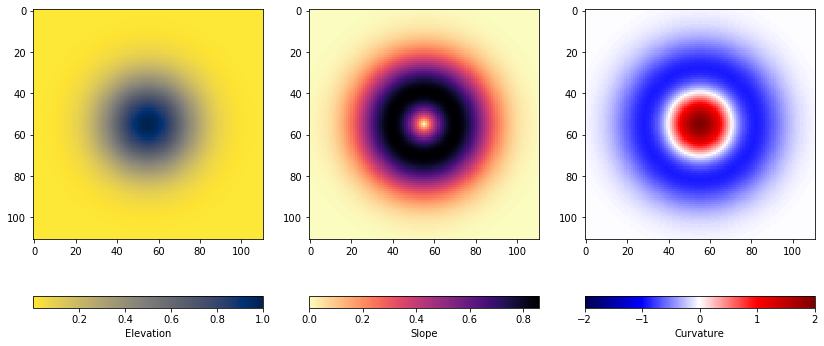

Text(0.5, 0, 'Z')

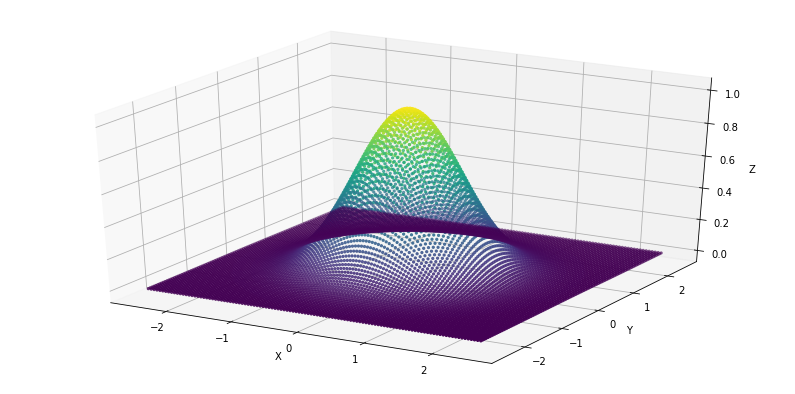

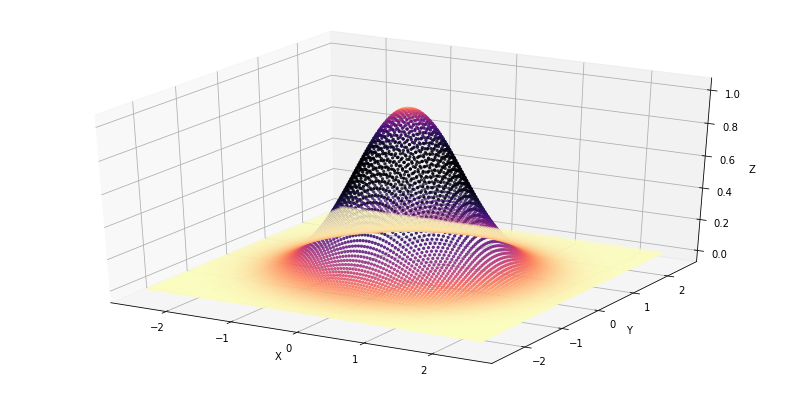

In [18]:
#Generating 2D plot
n = 111
fg, ax = pl.subplots(1, 3)
x, y, z = gaussian_hill_elevation(n)
im = ax[0].imshow(z, cmap = pl.cm.cividis_r)
cb = fg.colorbar(im, ax = ax[0], orientation = 'horizontal')
cb.set_label('Elevation')
im = ax[1].imshow(gaussian_hill_slope(n), cmap = pl.cm.magma_r)
cb = fg.colorbar(im, ax = ax[1], orientation = 'horizontal')
cb.set_label('Slope')
v = gaussian_hill_curvature(n)
vmax = v.max()
im = ax[2].imshow(v, cmap = pl.cm.seismic, vmin = -vmax, vmax = vmax)
cb = fg.colorbar(im, ax = ax[2], orientation = 'horizontal')
cb.set_label('Curvature')
pl.show()

# Plot 3D view using elevation as color code
from mpl_toolkits.mplot3d import Axes3D  
fig = pl.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x.ravel(), y.ravel(), z.ravel(), s=5, c=z.ravel(), cmap='viridis', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Plot 3D view using slope as color code
from mpl_toolkits.mplot3d import Axes3D  
fig = pl.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x.ravel(), y.ravel(), z.ravel(), s=5, c=gaussian_hill_slope(n).ravel(), cmap='magma_r', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

## Python implementation of a numerical Gaussian function for the first and second derivative
In the next step, we define a function, calculating the numerical derivative using numpy. This can be fed with the output grid from the Gaussian Hill and a first derivative can be calculated. Calling the function twice, will create the second derivative. We then plot the analytical and numerical solutions in map view.

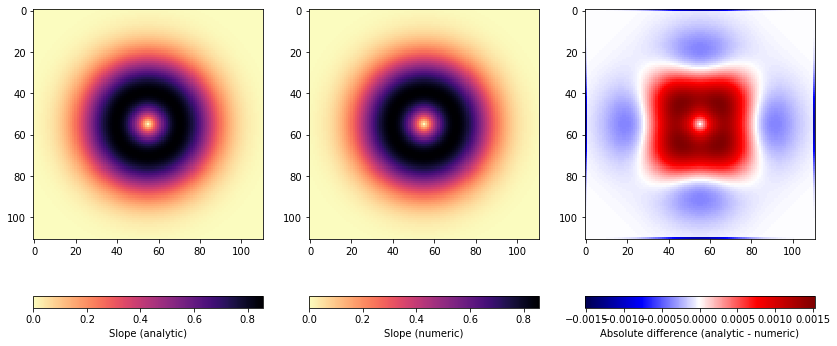

In [19]:
def np_slope(x, y, z):
    d = y[1,0] - y[0,0]
    dy, dx = np.gradient(z, d)
    return np.sqrt(dx*dx+dy*dy)

# Plot Analytical and numerical Slope analysis
fg, ax = pl.subplots(1, 3)
im = ax[0].imshow(gaussian_hill_slope(n), cmap = pl.cm.magma_r)
cb = fg.colorbar(im, ax = ax[0], orientation = 'horizontal')
cb.set_label('Slope (analytic)')

im = ax[1].imshow(np_slope(x, y, z), cmap = pl.cm.magma_r)
cb = fg.colorbar(im, ax = ax[1], orientation = 'horizontal')
cb.set_label('Slope (numeric)')

v = gaussian_hill_slope(n) - np_slope(x, y, z)
vmax = v.max()
im = ax[2].imshow(v, cmap = pl.cm.seismic, vmin = -vmax, vmax = vmax)
cb = fg.colorbar(im, ax = ax[2], orientation = 'horizontal')
cb.set_label('Absolute difference (analytic - numeric)')
pl.show()

Similarily, we can repeat this for the second derivative (curvature). We define a function that calculates the absolute curvature (irrespective of sign).

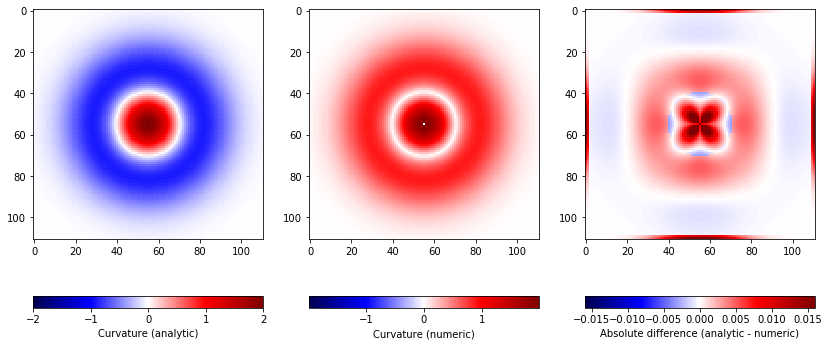

In [20]:
def np_abs_curvature(x, y, z):
    d = y[1,0] - y[0,0]
    dy, dx = np.gradient(z, d)
    dz = np.sqrt(dx*dx+dy*dy)
    dy, dx = np.gradient(dz, d)
    return np.sqrt(dx*dx+dy*dy)

# Plot Analytical and numerical Curvature analysis
fg, ax = pl.subplots(1, 3)
v = gaussian_hill_curvature(n)
vmax = v.max()
im = ax[0].imshow(v, cmap = pl.cm.seismic, vmin = -vmax, vmax = vmax)
cb = fg.colorbar(im, ax = ax[0], orientation = 'horizontal')
cb.set_label('Curvature (analytic)')

v = np_abs_curvature(x, y, z)
vmax = v.max()
im = ax[1].imshow(v, cmap = pl.cm.seismic, vmin = -vmax, vmax = vmax)
cb = fg.colorbar(im, ax = ax[1], orientation = 'horizontal')
cb.set_label('Curvature (numeric)')

v = np.abs(gaussian_hill_curvature(n)) - np_abs_curvature(x, y, z)
vmax = np.percentile(v, 99)
im = ax[2].imshow(v, cmap = pl.cm.seismic, vmin = -vmax, vmax = vmax)
cb = fg.colorbar(im, ax = ax[2], orientation = 'horizontal')
cb.set_label('Absolute difference (analytic - numeric)')
pl.show()

# Comparing Slope distributions from analytical and numerical solution
Understanding slope distributions is a core step to understand landscape evolution and landscape regime (dynamics, steady state, transient). Using high-resolution DEMs, it is important to have a thorough understanding of slopes. In addition to the visual comparison shown above, we can analyse the slope distributions in a more quantitative fashion, to estimate uncertainties.

Text(0.5, 1.0, 'Gaussian Hill with 11 x 11 elements')

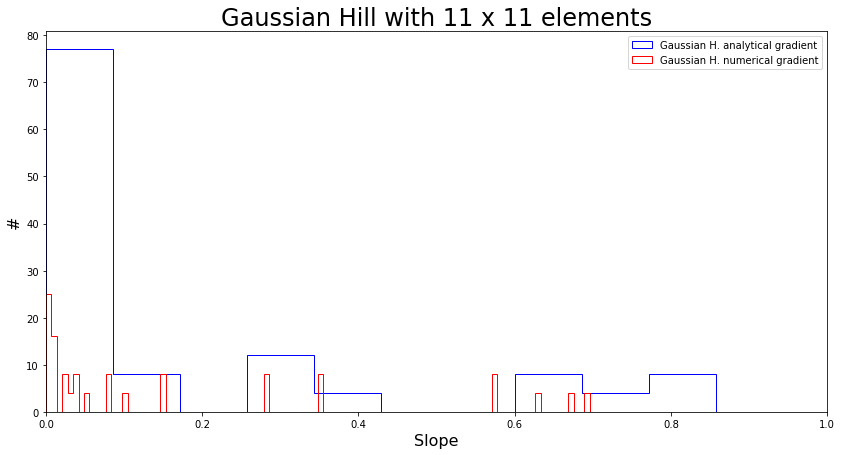

In [21]:
# Slope Distributions
n=11
x, y, z = gaussian_hill_elevation(n)
G_grad = gaussian_hill_slope(n)
G_numerical_grad = np_slope(x, y, z)
G_grad_p = np.percentile(G_grad.ravel(), [5,10,25,50,75,90,95])
G_numerical_grad_p = np.percentile(G_numerical_grad.ravel(), [5,10,25,50,75,90,95])

fg, ax = pl.subplots(1, 1)
ax.hist(G_grad.ravel(), bins=10, color='b', histtype='step', label='Gaussian H. analytical gradient')
ax.set_xlabel('Slope', fontsize=16)
ax.set_ylabel('#', fontsize=16)
ax.set_xlim((0, 1))
ax.hist(G_numerical_grad.ravel(), bins=100, color='r', histtype='step', label='Gaussian H. numerical gradient')
ax.legend()
ax.set_title('Gaussian Hill with %d x %d elements'%(n,n), fontsize=24 )

For a coarse DEM (few elements, in this case 11x11), the discrepancy between analytical solution and numerical solution is very large.

Text(0.5, 1.0, 'Gaussian Hill with 111 x 111 elements')

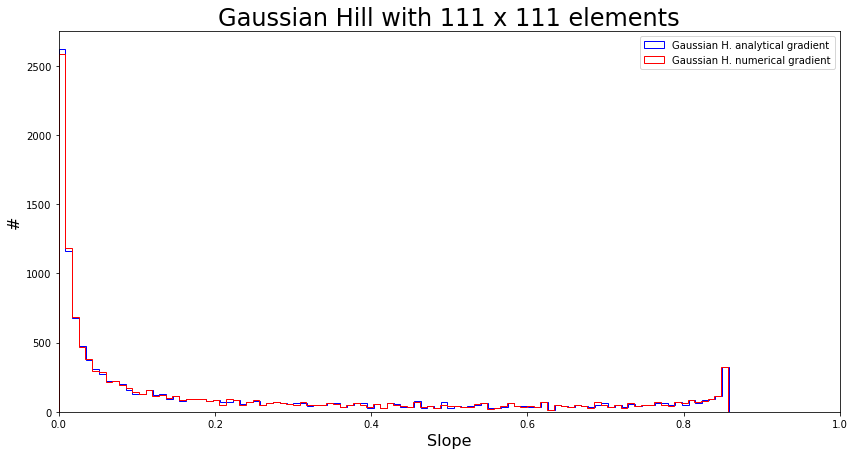

In [22]:
n=111
x, y, z = gaussian_hill_elevation(n)
G_grad = gaussian_hill_slope(n)
G_numerical_grad = np_slope(x, y, z)
G_grad_p = np.percentile(G_grad.ravel(), [5,10,25,50,75,90,95])
G_numerical_grad_p = np.percentile(G_numerical_grad.ravel(), [5,10,25,50,75,90,95])

fg, ax = pl.subplots(1, 1)
ax.hist(G_grad.ravel(), bins=100, color='b', histtype='step', label='Gaussian H. analytical gradient')
ax.set_xlabel('Slope', fontsize=16)
ax.set_ylabel('#', fontsize=16)
ax.set_xlim((0, 1))
ax.hist(G_numerical_grad.ravel(), bins=100, color='r', histtype='step', label='Gaussian H. numerical gradient')
ax.legend()
ax.set_title('Gaussian Hill with %d x %d elements'%(n,n), fontsize=24 )

For a 111x111 element array, the slope distributions match better. Note that a 111x111 array with a 1-m high Gaussian hill and length and width of 5 m, roughly corresponds to 5/111 = 0.45 m/pixel DEM - a very high resolution. 11x11 corresponds to 4.5m/pixel.

Text(0.5, 1.0, 'Gaussian Hill with 1111 x 1111 elements')

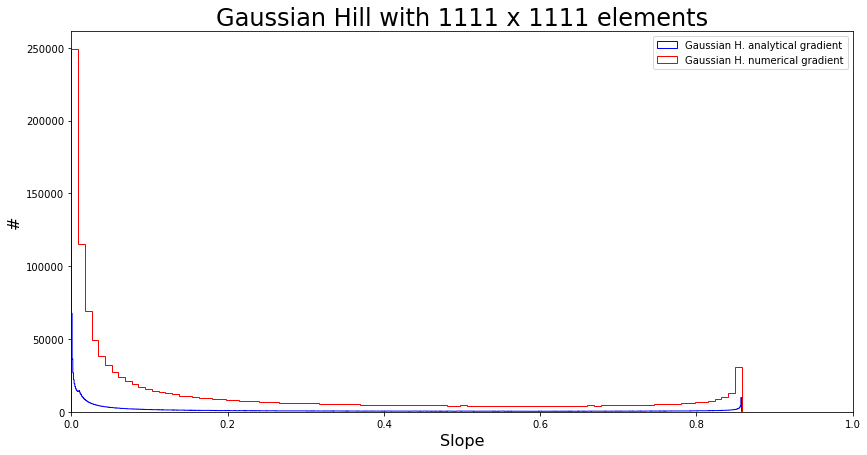

In [23]:
n=1111
x, y, z = gaussian_hill_elevation(n)
G_grad = gaussian_hill_slope(n)
G_numerical_grad = np_slope(x, y, z)
G_grad_p = np.percentile(G_grad.ravel(), [5,10,25,50,75,90,95])
G_numerical_grad_p = np.percentile(G_numerical_grad.ravel(), [5,10,25,50,75,90,95])

fg, ax = pl.subplots(1, 1)
ax.hist(G_grad.ravel(), bins=1000, color='b', histtype='step', label='Gaussian H. analytical gradient')
ax.set_xlabel('Slope', fontsize=16)
ax.set_ylabel('#', fontsize=16)
ax.set_xlim((0, 1))
ax.hist(G_numerical_grad.ravel(), bins=100, color='r', histtype='step', label='Gaussian H. numerical gradient')
ax.legend()
ax.set_title('Gaussian Hill with %d x %d elements'%(n,n), fontsize=24 )

# Resampling of DEMs
In the next step, we will first subsample a gridded Gaussian Hill (i.e., take only every other data point) and then perform resampling onto the original grid size to decipher artefacts of resampling methods. The example below only uses bilinear resampling, but you can modify this to higher-order resampling methods.

Text(0.5, 0, 'Z')

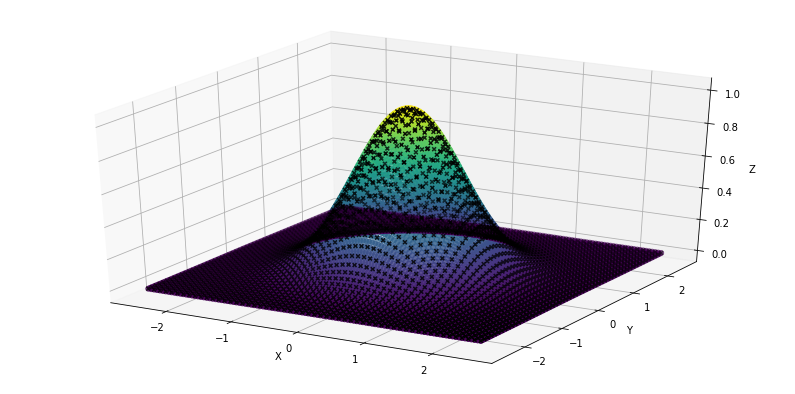

In [24]:
n=111
x, y, z = gaussian_hill_elevation(n)
G_grad = gaussian_hill_slope(n)
xs = x[::2, ::2]
ys = y[::2, ::2]
zs = z[::2, ::2]

# Plot 3D view using elevation as color code and subsampled data
from mpl_toolkits.mplot3d import Axes3D  
fig = pl.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x.ravel(), y.ravel(), z.ravel(), s=25, c=z.ravel(), cmap='viridis', marker='o')
ax.scatter(xs.ravel(), ys.ravel(), zs.ravel(), s=15, c='k', marker='x')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

Now we have a subsampled array containing only every other datapoint in 'zs'. Using the corresponding x and y coordinates (using linspace to build these vectors), we can interpolate onto a function describing the Gaussian Hill

In [25]:
#Interpolate to surface with higher density
#scipy.interpolate.interp2d(x, y, z, kind='linear', copy=True, bounds_error=False, fill_value=nan)[source]
from scipy.interpolate import interp2d
b=2.5
x_elementsi = np.linspace(-b,b,n)[::2]
y_elementsi = np.linspace(-b,b,n)[::2]
zsi = interp2d(x_elementsi, y_elementsi, zs, kind='linear')

x_elementsi = np.linspace(-b,b,n)
y_elementsi = np.linspace(-b,b,n)
zi = zsi(x_elementsi, y_elementsi)

Now zi contains has the same grid size as the original (full resolution) dataset. This can be plotted and used for further analysis.

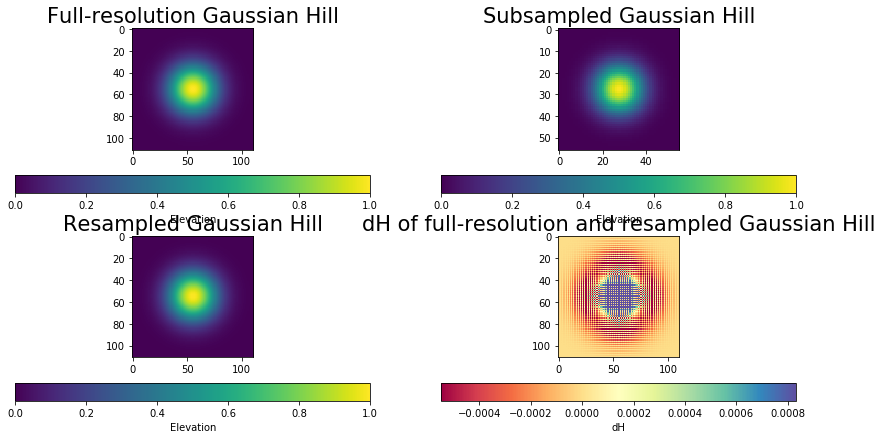

In [26]:
fg, ax = pl.subplots(2, 2)
vmin = 0
vmax = 1
im = ax[0,0].imshow(z, cmap = pl.cm.viridis, vmin = vmin, vmax = vmax)
ax[0,0].set_title('Full-resolution Gaussian Hill', fontsize=21)
cb = fg.colorbar(im, ax = ax[0,0], orientation = 'horizontal')
cb.set_label('Elevation')

im = ax[0,1].imshow(zs, cmap = pl.cm.viridis, vmin = vmin, vmax = vmax)
ax[0,1].set_title('Subsampled Gaussian Hill', fontsize=21)
cb = fg.colorbar(im, ax = ax[0,1], orientation = 'horizontal')
cb.set_label('Elevation')

im = ax[1,0].imshow(zi, cmap = pl.cm.viridis, vmin = vmin, vmax = vmax)
ax[1,0].set_title('Resampled Gaussian Hill', fontsize=21)
cb = fg.colorbar(im, ax = ax[1,0], orientation = 'horizontal')
cb.set_label('Elevation')

dh = z-zi
im = ax[1,1].imshow(dh, cmap = pl.cm.Spectral, vmin = np.percentile(dh.ravel(),5), vmax = np.percentile(dh.ravel(),95))
ax[1,1].set_title('dH of full-resolution and resampled Gaussian Hill', fontsize=21)
cb = fg.colorbar(im, ax = ax[1,1], orientation = 'horizontal')
cb.set_label('dH')


**Question: Experiment with the different resampling method in [scipy.interpolate.interp2d](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.interp2d.html). What is the difference to ‘cubic’ and ‘quintic’?**

**Question: Calculate the slope distribution of the resampled data (for 'linear'). Where and why do you observe the largest differences?**